In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from tqdm import tqdm
from dataset import myDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define device variable for cuda, mps or cpu

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')
else :
    device = torch.device('cpu')
    print('Using CPU')


Using MPS


In [3]:
#We want to use a resnet50 from torchvision to have the embedding of an image, use a pretrained resnet and remove the last layer

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.resnet.eval()
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)

In [4]:
class ClusteringModel(nn.Module):
    def __init__(self, embedding_size, num_clusters):
        super(ClusteringModel, self).__init__()
        self.num_embeddings = embedding_size
        self.num_clusters = num_clusters
        self.centers = nn.Parameter(torch.randn(num_clusters, embedding_size))

    def forward(self, embeddings):
        embeddings = embeddings.flatten(2).flatten(1)
        # Compute the distance between each embedding and each cluster center
        distances = torch.cdist(embeddings, self.centers)
        # Assign each embedding to the closest cluster
        assignments = torch.argmin(distances, dim=1)
        return assignments

In [5]:
def clustering_loss(model, embeddings):
    assignments = model(embeddings)
    # Compute the loss as the sum of the distances between each embedding and its assigned cluster center
    embeddings = embeddings.flatten(2).flatten(1)
    distances = torch.cdist(embeddings, model.centers)
    loss = torch.sum(torch.gather(distances, 1, assignments.unsqueeze(1)))
    return loss

In [6]:
resnet_model = ResNet().to(device)

Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#Create the dataset

get_preprocessed_image = True
train_test_split = 0.9
my_path_hm = os.path.join(os.getcwd(), 'data/h&mdataset/images/')
my_path_fash = os.path.join(os.getcwd(), 'data/fashion-dataset/images/')

dataset = myDataset(my_path_hm, my_path_fash, get_preprocessed_image, 'hm')

#Split the dataset into training and testing
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=10, pin_memory=True)

In [29]:
#Choice of cluster number : we have 143 article type 20 color, so a number between 100 et 300 can be a good choice

In [8]:
embeddings_size = 2048
range_of_n_clusters = range(200,201)

In [31]:
# Initialize a list to hold the loss for each number of clusters
losses = []

# Loop over different numbers of clusters
for num_clusters in range_of_n_clusters:  # Adjust the range as needed
    # Initialize the clustering model
    clustering_model = ClusteringModel(embeddings_size, num_clusters).to(device)  # Assuming that 'model.embedding_size' is the size of your embeddings

    # Initialize the optimizer
    optimizer = optim.Adam(clustering_model.parameters(), lr=0.001)  # Adjust the learning rate as needed

    # Train the clustering model
    num_epochs = 1  # Adjust as needed
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        for batch in tqdm(train_loader):
            imgs, _, _ = batch
            imgs = imgs.to(device)
            optimizer.zero_grad()
            embeddings = resnet_model(imgs)  # Compute the embeddings for the current batch of images
            loss = clustering_loss(clustering_model, embeddings)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

Epoch 1/1


  0%|          | 0/1478 [00:00<?, ?it/s]

  2%|▏         | 30/1478 [00:27<21:45,  1.11it/s] 


KeyboardInterrupt: 

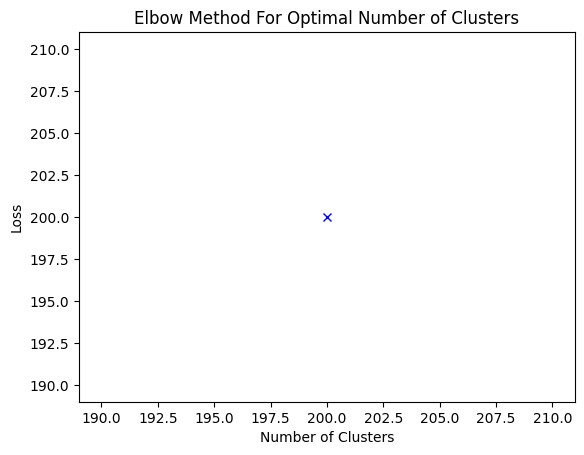

In [32]:
losses = [200.0]
# Plot the elbow graph
plt.plot(range_of_n_clusters, losses, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Elbow Method For Optimal Number of Clusters')
#save the plot
plt.savefig('models/ElbowGraphs/elbow_plot_img.png')
plt.show()

In [9]:
#Define the final number of clusters

num_clusters = 200

In [10]:
# Initialize the clustering model and train it

clustering_model = ClusteringModel(embeddings_size, num_clusters).to(device)
optimizer = optim.Adam(clustering_model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    for batch in tqdm(train_loader):
        imgs, _, _ = batch
        imgs = imgs.to(device)
        optimizer.zero_grad()
        embeddings = resnet_model(imgs)
        loss = clustering_loss(clustering_model, embeddings)
        loss.backward()
        optimizer.step()



  0%|          | 0/1478 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [35]:
# Save the model
torch.save(clustering_model.state_dict(), 'models/clustering_model_img.pth')

In [36]:
#Save in a dataframe, the name of training images and their cluster prediction

# Initialize a list to hold the predictions
predictions = []

# Loop over the training images
for batch in tqdm(train_loader):
    imgs, idx, img_paths = batch
    imgs = imgs.to(device)
    embeddings = resnet_model(imgs)
    cluster = clustering_model(embeddings)
    for i in range(len(idx)):
        predictions.append({'image': img_paths[i], 'cluster': cluster[i].item()})

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Save the DataFrame
predictions_df.to_csv('train_predictions_img.csv', index=False)

100%|██████████| 1478/1478 [08:33<00:00,  2.88it/s]


In [11]:
# Idem for the test dataset 

# Initialize a list to hold the predictions
predictions = []

# Loop over the test images
for batch in tqdm(test_loader):
    imgs, idx, img_paths = batch
    imgs = imgs.to(device)
    embeddings = resnet_model(imgs)
    cluster = clustering_model(embeddings)
    for i in range(len(idx)):
        predictions.append({'image': img_paths[i], 'cluster': cluster[i].item()})

# Convert the list to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Save the DataFrame
predictions_df.to_csv('test_predictions_img.csv', index=False)

 84%|████████▍ | 277/329 [04:13<00:49,  1.04it/s]